In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [6]:
from tfumap.umap import tfUMAP

### Load dataset

In [72]:
dataset = 'macosko2015'
dims = (50)

In [8]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [9]:
#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

In [10]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [11]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.1, random_state=42)

In [14]:
np.shape(X_train)

(40327, 50)

In [15]:
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

In [16]:
X_train_flat = X_train

In [17]:
X_test_flat = X_test

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [19]:
Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).flatten()

### Create model and train

In [20]:
n_components = 64
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [21]:
batch_size = 5000

In [22]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [23]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [24]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [25]:
X_train_subset = X_train[:np.product(P.shape[:2])]

In [26]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train_subset.shape[0], -1)

In [27]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [28]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [29]:
X_train_subset = np.reshape(X_train_subset, ([len(X_train_subset)]+ [dims]))
X_test = np.reshape(X_test, ([len(X_test)]+ [dims]))

In [30]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train_subset, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 12:42:39.288091 139730880911168 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 30000 samples
Epoch 1/1000
30000/30000 [==============================] - 7s 222us/sample - loss: 2.7554
Epoch 2/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 1.4821
Epoch 3/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 1.2178
Epoch 4/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.0661
Epoch 5/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.9739
Epoch 6/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.9036
Epoch 7/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.8497
Epoch 8/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.8078
Epoch 9/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.7747
Epoch 10/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.7483
Epoch 11/1000
30000/30000 [==============================] - 0s 11us/sample

30000/30000 [==============================] - 0s 11us/sample - loss: 0.4165
Epoch 180/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.4187
Epoch 181/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.4190
Epoch 182/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 0.4211
Epoch 183/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 0.4192
Epoch 184/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 0.4191
Epoch 185/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.4149
Epoch 186/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.4165
Epoch 187/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.4146
Epoch 188/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 0.4155
Epoch 189/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.4183
Epo

30000/30000 [==============================] - 0s 11us/sample - loss: 0.3920
Epoch 358/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3923
Epoch 359/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3915
Epoch 360/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3903
Epoch 361/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 0.3901
Epoch 362/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3869
Epoch 363/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3877
Epoch 364/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3863
Epoch 365/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3858
Epoch 366/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3892
Epoch 367/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3889
Epo

30000/30000 [==============================] - 0s 11us/sample - loss: 0.3912
Epoch 536/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3941
Epoch 537/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3937
Epoch 538/1000
30000/30000 [==============================] - 1s 17us/sample - loss: 0.3901
Epoch 539/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 0.3887
Epoch 540/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3890
Epoch 541/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.3886
Epoch 542/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3864
Epoch 543/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 0.3851
Epoch 544/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3854
Epoch 545/1000
30000/30000 [==============================] - 0s 10us/sample - loss: 0.3837
Epo

30000/30000 [==============================] - 0s 14us/sample - loss: 0.3707
Epoch 714/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3732
Epoch 715/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3715
Epoch 716/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3717
Epoch 717/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 0.3744
Epoch 718/1000
30000/30000 [==============================] - 1s 17us/sample - loss: 0.3761
Epoch 719/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3729
Epoch 720/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3741
Epoch 721/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3727
Epoch 722/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 0.3730
Epoch 723/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 0.3743
Epo

30000/30000 [==============================] - 0s 17us/sample - loss: 0.3716
Epoch 892/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3703
Epoch 893/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3704
Epoch 894/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3732
Epoch 895/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 0.3703
Epoch 896/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 0.3713
Epoch 897/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3717
Epoch 898/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3681
Epoch 899/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3667
Epoch 900/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 0.3666
Epoch 901/1000
30000/30000 [==============================] - 1s 17us/sample - loss: 0.3675
Epo

### get z for training and test

In [31]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

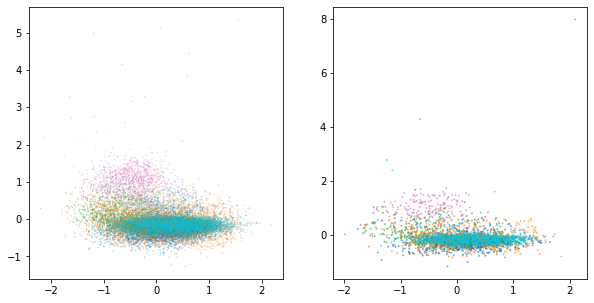

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train, cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [33]:
import os

In [73]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' / 'parametric-tsne'
output_dir

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/parametric-tsne')

In [74]:
encoder.save(os.path.join(output_dir, "encoder"))

I0723 11:36:54.569936 139730880911168 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/parametric-tsne/encoder/assets


In [75]:
output_dir

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/parametric-tsne')

In [76]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [37]:
from tfumap.silhouette import silhouette_score_block

In [38]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

-0.021431519661098564

In [39]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

-0.02625966097104412

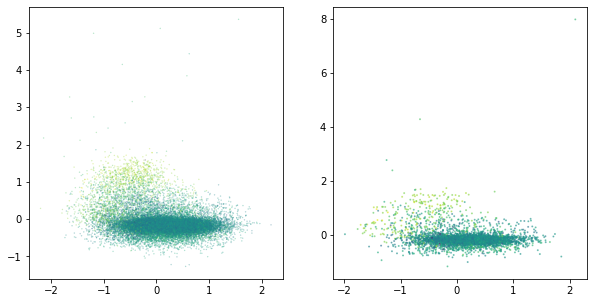

In [40]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.981254184333854

In [43]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9772372238339656

#### Trustworthiness

In [44]:
from sklearn.manifold import trustworthiness

In [45]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [46]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [47]:
tw, tw_test

(0.9917757285828663, 0.98765861054397)

#### save output metrics

In [57]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,macosko2015,parametric-tsne,64,0.991776,-0.021432,"[-0.08902739890354991, 0.31910139972405144, 0...."


In [58]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [59]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,macosko2015,parametric-tsne,64,0.987659,-0.02626,"[-0.015183595472137964, -0.01295052244733406, ..."


In [60]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [61]:
save_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/projection_metrics/test/64/macosko2015.pickle')

In [62]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,64,macosko2015,0.977237,0.981254


In [63]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

In [64]:
save_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/knn_classifier/64/macosko2015.pickle')